<a href="https://colab.research.google.com/github/Ashish-Tripathy/ComputerVision/blob/master/Assignment_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Libraries

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import *
from keras.models import load_model
import cv2
import sys
from google.colab.patches import cv2_imshow

# Loading the Cifar Data

In [0]:
!mv '/content/gdrive/My Drive/cifar-10-python.tar.gz' '/content/cifar-10-batches-py.tar.gz'

In [0]:
!cp 'cifar-10-batches-py.tar.gz' ~/.keras/datasets/

In [0]:
ls ~/.keras/datasets/

cifar-10-batches-py.tar.gz  cifar-10-python.tar.gz


In [0]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

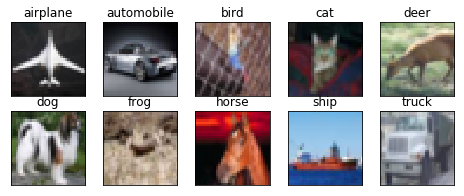

In [0]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

# Defining Functions for Model Stats

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

# Data preprocessing

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Building the Architecture
1. Introduce Batchnormalisation after every convolution
2. Dropout with rate of 0.2
3. Max RF targeted at 26x26 before we apply the large convolution

In [0]:
from keras.models import Model
from keras.layers import Input,Conv2D, BatchNormalization,Activation, Flatten
from keras.regularizers import l2

input = Input(shape=(32, 32, 3,))

#defining convolution block
def conv_block(inputs, filters,padding = 'valid'):
  conv = Conv2D(filters = filters, kernel_size = (3,3), padding=padding, use_bias=False 
               # , kernel_regularizer = l2(1E-4)
               )(inputs)     
  conv = Dropout(0.2)(conv)
  conv = BatchNormalization()(conv) # BN before ReLu
  conv = Activation('relu')(conv)
  return conv

#defining transition block
def bottleneck(inputs,filters):
  conv = Conv2D(filters = filters, kernel_size = (1,1), padding = 'valid', use_bias = False)(inputs)
  conv = Dropout(0.2)(conv)
  conv = BatchNormalization()(conv)
  conv = Activation('relu')(conv)
  return MaxPooling2D()(conv)

#Building the architecture
First_Layer  =  conv_block(input, 32, padding = 'same')                    #ip = 32, RF = 3x3
Second_Layer =  conv_block(First_Layer,64, padding = 'valid')              #ip = 32, RF = 5x5
Third_Layer  =  conv_block(Second_Layer,128, padding = 'valid')            #ip = 30, RF = 7x7
Fourth_Layer =  conv_block(Third_Layer,256, padding = 'valid')             #ip = 28, RF = 9x9
Transition_1 =  bottleneck(Fourth_Layer,64)                                #ip = 26, RF = 18x18
Fifth_Layer  =  conv_block(Transition_1,64, padding = 'same')             #ip = 13, RF = 20x20
Sixth_Layer  =  conv_block(Fifth_Layer,128, padding = 'valid')             #ip = 13, RF = 22x22 
Seventh_Layer=  conv_block(Sixth_Layer,256, padding = 'valid')             #ip = 11, RF = 24x24
Eigth_Layer  =  conv_block(Seventh_Layer,512, padding = 'valid')          #ip = 9, RF = 26x26


last1x1      =  Conv2D(filters = 10, kernel_size = (1,1), padding = 'valid', use_bias = False)(Eigth_Layer)
last1x1      =  Activation('relu')(last1x1)
last_layer   =  Conv2D(filters = 10, kernel_size = (7,7), padding = 'valid', use_bias = False)(last1x1) 
flatten      =  Flatten()(last_layer)
output       =  Activation('softmax')(flatten)

#creating the model
model = Model(inputs=[input], outputs=[output])
#model = Model(inputs=[input], outputs=[last1x1])
model.summary()
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


W0624 11:18:20.189604 140290771621760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 11:18:20.207420 140290771621760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 11:18:20.211710 140290771621760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0624 11:18:20.226538 140290771621760 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0624 11:18:20.238286 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        864       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18432     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 64)        0         
__________

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Mounted at /content/gdrive


## Training the Model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 49s 125ms/step - loss: 1.5707 - acc: 0.4433 - val_loss: 2.2510 - val_acc: 0.3394

Epoch 00001: val_acc improved from -inf to 0.33940, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg6Cifar_4thJune:001-val_acc:0.339.hdf5
Epoch 2/100
390/390 [==============================] - 47s 119ms/step - loss: 1.1070 - acc: 0.6293 - val_loss: 1.5432 - val_acc: 0.5306

Epoch 00002: val_acc improved from 0.33940 to 0.53060, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg6Cifar_4thJune:002-val_acc:0.531.hdf5
Epoch 3/100
390/390 [==============================] - 46s 118ms/step - loss: 0.8814 - acc: 0.7083 - val_loss: 1.2033 - val_acc: 0.6007

Epoch 00003: val_acc improved from 0.53060 to 0.60070, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg6Cifar_4thJune:003-val_acc:0.601.hdf5
Epoch 4/100
390/390 [==============================] - 46s 118ms/step - loss: 0.7576 - acc: 0.7522 - val_loss: 0.7887 - val_acc: 0.73

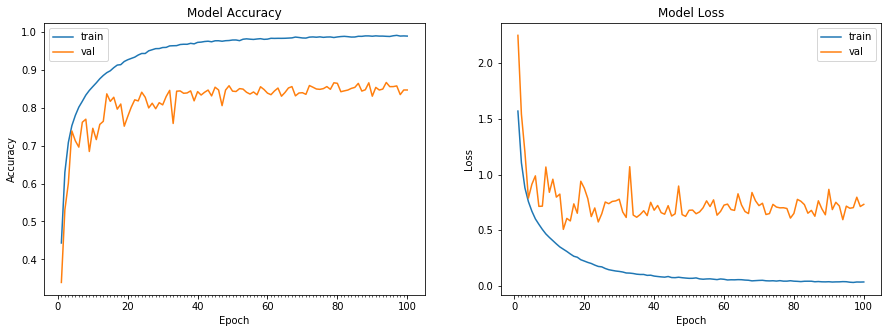

Accuracy on test data is: 84.64


In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)




filepath="/content/gdrive/My Drive/Colab Notebooks/Asg6Cifar_4thJune:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='auto')

callback_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callback_list )


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


#### Better accuracy of 83.62 was achieved by 14th epoch.
#### Best accuracy of 86.62 was achieved by 94th epoch

# GradCAM

## Loading the model with best accuracy

In [0]:
modelPath = '/content/gdrive/My Drive/Colab Notebooks/Asg6Cifar_4thJune:094-val_acc:0.866.hdf5'
model = load_model(modelPath)
print ("Accuracy on test data from best trained model is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data from best trained model is: 86.62


## Defining functions for implementation

### Predicting on the image

In [0]:
def test_img_predict(img,img_num):
  class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
  preds = model.predict(img)
  actual_label = np.argmax(test_labels[img_num])
  class_idx = np.argmax(preds)
  class_output = model.output[:, class_idx]
  print("Original Class:",class_names[actual_label],";", "Predicted Class:",class_names[class_idx] )
  return class_output

To check the map for the top prediction, we take the topmost class index.

### Selecting the output from the final convolution layer and computing gradient with class output

In [0]:
def gradient_FeatureHeatMap(last_conv_name, class_output, channel_num,img_pr):
  last_conv_layer = model.get_layer(last_conv_name)
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_pr])
  for i in range(channel_num):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  return heatmap

We compute the gradient of the class output value with respect to the feature map. Then, we pool the gradients over all the axes leaving out the channel dimension. Finally, we weigh the output feature map with the computed gradient values. We also evaluate the heatmap by averaging the weighed feature map

### Defining the function to plot Gradient weighted Class Activation Map (GradCAM)

In [0]:
def plot_gradCAM(heatmap, img):  
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  img = np.uint8(255*img)
  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0) 
  fig=plt.figure(figsize=(5, 5))
  ax1 = fig.add_subplot(2,2,1)
  ax1.set_title('Original')
  ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  ax2 = fig.add_subplot(2,2,2)
  ax2.set_title('GradCAM')
  ax2.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
  plt.show()


Adds the heatmap with the image with more weights to image. A superimposed image is obtained which has brighter pixels where the activation happens

## Plotting GradCAM for a test image

Original Class: automobile ; Predicted Class: automobile


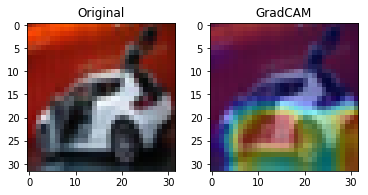

In [0]:
img = test_features[6,:,:] #selecting some random image by explicitly mentioning the image number
img_pr = np.expand_dims(img, axis=0)
class_output = test_img_predict(img_pr,6)
heatmap = gradient_FeatureHeatMap("conv2d_51",class_output, 512,img_pr)
plot_gradCAM(heatmap,img)


## Plotting for four test images

Original Class: frog ; Predicted Class: frog


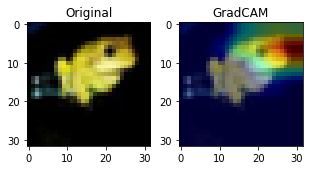

Original Class: cat ; Predicted Class: deer


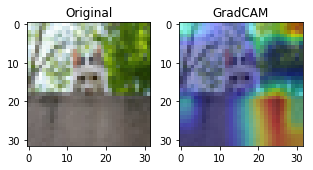

Original Class: cat ; Predicted Class: bird


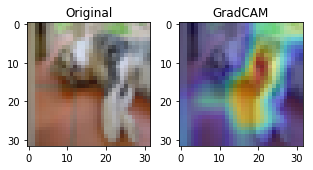

Original Class: deer ; Predicted Class: bird


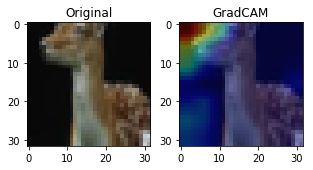

In [0]:
np.random.seed(123)
#np.random.seed(3)

for i in range(4):
  img_num = np.random.randint(test_features.shape[0])
  img = test_features[img_num]
  img_pr = np.expand_dims(img, axis=0)
  class_output = test_img_predict(img_pr,img_num)
  heatmap = gradient_FeatureHeatMap("conv2d_51",class_output, 512,img_pr)
  plot_gradCAM(heatmap,img)

# Cut Out Image Augmentation Technique

Cut out is an Image augmentation technique that regularizes a model by randomly masking training images with random values.

## Implementation of Cut out
Source - https://github.com/yu4u/cutout-random-erasing/blob/master/random_eraser.py

In [0]:
import numpy as np


def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

### Testing Cutout on single image

W0624 15:03:38.621009 140290771621760 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


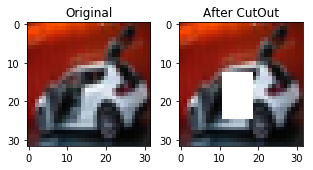

In [0]:
eraser = get_random_eraser()
img = test_features[6,:,:]
# load image to img
fig=plt.figure(figsize=(5, 5))
ax1 = fig.add_subplot(2,2,1)
ax1.set_title('Original')
ax1.imshow(img)
img_cutout = eraser(img)
ax2 = fig.add_subplot(2,2,2)
ax2.set_title('After CutOut')
ax2.imshow(img_cutout)
plt.show()

## Create Image Generator using the custom Cut Out augmentation

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))
                             



## Retraining the model

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<keras.ca..., steps_per_epoch=390, epochs=100)`
  # This is added back by InteractiveShellApp.init_path()
W0624 11:19:01.086430 140290771621760 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_d

Epoch 1/100
390/390 [==============================] - 91s 233ms/step - loss: 1.7095 - acc: 0.3611 - val_loss: 2.6914 - val_acc: 0.3149

Epoch 00001: val_acc improved from -inf to 0.31490, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg9_24thJune:001-val_acc:0.315.hdf5
Epoch 2/100
390/390 [==============================] - 88s 225ms/step - loss: 1.3375 - acc: 0.5125 - val_loss: 1.5496 - val_acc: 0.5026

Epoch 00002: val_acc improved from 0.31490 to 0.50260, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg9_24thJune:002-val_acc:0.503.hdf5
Epoch 3/100
390/390 [==============================] - 87s 223ms/step - loss: 1.1328 - acc: 0.5930 - val_loss: 1.1295 - val_acc: 0.6268

Epoch 00003: val_acc improved from 0.50260 to 0.62680, saving model to /content/gdrive/My Drive/Colab Notebooks/Asg9_24thJune:003-val_acc:0.627.hdf5
Epoch 4/100
390/390 [==============================] - 87s 223ms/step - loss: 1.0027 - acc: 0.6424 - val_loss: 1.2495 - val_acc: 0.6047

Epoch 00

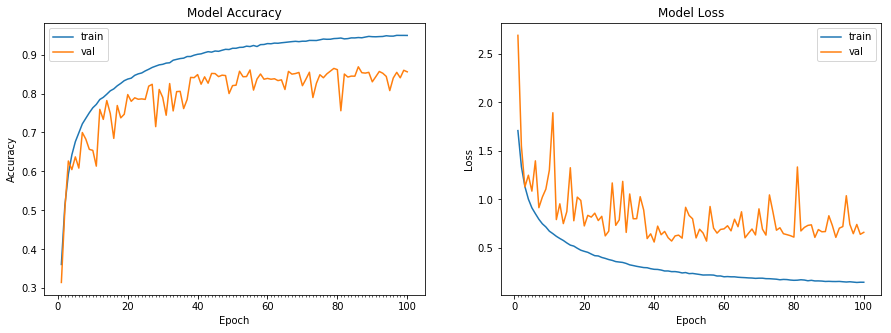

Accuracy on test data is: 85.58


In [0]:
filepath="/content/gdrive/My Drive/Colab Notebooks/Asg9_24thJune:{epoch:03d}-val_acc:{val_acc:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True,save_weights_only=False, mode='auto')

callback_list = [checkpoint]

# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1,callbacks = callback_list )


end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

## Plotting GradCAM for the retrained model

### Loading the best model

In [0]:
modelPath = '/content/gdrive/My Drive/Colab Notebooks/Asg9_24thJune:086-val_acc:0.869.hdf5'
model = load_model(modelPath)
print ("Accuracy on test data from best trained model is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data from best trained model is: 86.87


Got 0.25% increase in the accuracy from the previous trained model without cut out with reduced overfitting.

### Plotting GradCAM

Original Class: frog ; Predicted Class: frog


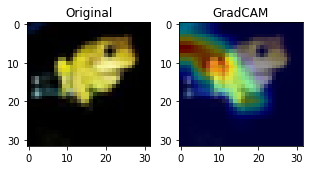

Original Class: cat ; Predicted Class: cat


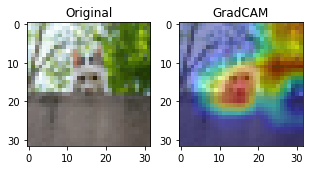

Original Class: cat ; Predicted Class: dog


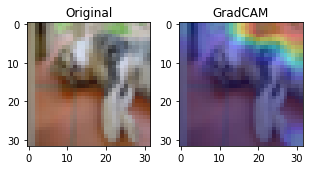

Original Class: deer ; Predicted Class: bird


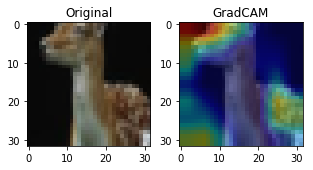

In [0]:
np.random.seed(123)
#np.random.seed(3)

for i in range(4):
  img_num = np.random.randint(test_features.shape[0])
  img = test_features[img_num]
  img_pr = np.expand_dims(img, axis=0)
  class_output = test_img_predict(img_pr,img_num)
  heatmap = gradient_FeatureHeatMap("conv2d_9",class_output, 512,img_pr)
  plot_gradCAM(heatmap,img)

The most interesting case is the 2nd case. If you see the GradCAM for previous model, the cat was not at all detected, as its body is completely obscured by a wall. The convolution was not at all getting activated in the regions of the cat, but in the Cut Out case you can see that it easily detects cat case as it can see cat even though its body obscured by the wall.